In [1]:
import pandas as pd
from pandas import Timestamp
import statsmodels
from operator import itemgetter
import string
import numpy as np
from collections import Counter
from sklearn.metrics import accuracy_score,classification_report
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords as sw
from nltk.corpus import wordnet as wn
from nltk import wordpunct_tokenize
from nltk import WordNetLemmatizer
from nltk import sent_tokenize
from nltk import pos_tag
from nltk import bigrams
from nltk import word_tokenize
from nltk.sentiment.util import mark_negation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.base import TransformerMixin
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier


/home/kim/anaconda3/lib/python3.5/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


### Create pipelines for each classifier (to be used further down)

In [2]:
# 1) LOGISTIC REGRESSION
trigram_clf = Pipeline([


    ('vectorizer', CountVectorizer(analyzer="word",
                                   ngram_range=(1, 3),
                                   tokenizer=word_tokenize,         # ! Comment line to include mark_negation and uncomment next line
                                   #tokenizer=lambda text: mark_negation(word_tokenize(text)),
                                   #preprocessor=lambda text: text.replace("<br />", " "),
                                   max_features=10000)),
    ('transformer', TfidfTransformer()) ,    # or any other classifier deemed useful!
    ('classifier', LogisticRegression(C=2.0, penalty='l2'))     # or any other classifier deemed useful!
    
   
])

# 2) SUPPORT VECTOR MACHINES
svm_trigram_clf = Pipeline([


    ('vectorizer', CountVectorizer(analyzer="word",
                                   ngram_range=(1, 3),
                                   tokenizer=word_tokenize,         # ! Comment line to include mark_negation and uncomment next line
                                   #tokenizer=lambda text: mark_negation(word_tokenize(text)),
                                   #preprocessor=lambda text: text.replace("<br />", " "),
                                   max_features=10000)),

    ('classifier', LinearSVC())     # or any other classifier deemed useful!
    
   
])


# 3) NAIVE BAYES
NB_trigram_clf = Pipeline([


    ('vectorizer', CountVectorizer(analyzer="word",
                                   ngram_range=(1, 3),
                                   tokenizer=word_tokenize,         # ! Comment line to include mark_negation and uncomment next line
                                   #tokenizer=lambda text: mark_negation(word_tokenize(text)),
                                   #preprocessor=lambda text: text.replace("<br />", " "),
                                   max_features=10000)),

    ('classifier', MultinomialNB())     # or any other classifier deemed useful!
    
   
])

# 4) STOCHASTIC GRADIENT DESCENT REGRESSION
SGD_trigram_clf = Pipeline([


    ('vectorizer', CountVectorizer(analyzer="word",
                                   ngram_range=(1, 3),
                                   tokenizer=word_tokenize,         # ! Comment line to include mark_negation and uncomment next line
                                   #tokenizer=lambda text: mark_negation(word_tokenize(text)),
                                   #preprocessor=lambda text: text.replace("<br />", " "),
                                   max_features=10000)),

    ('classifier', SGDClassifier())     # or any other classifier deemed useful!
    
   
])

# 5) RANDOM FORESTS
random_clf = Pipeline([


    ('vectorizer', CountVectorizer(analyzer="word",
                                   ngram_range=(1, 2),
                                   tokenizer=word_tokenize,         # ! Comment line to include mark_negation and uncomment next line
                                   #tokenizer=lambda text: mark_negation(word_tokenize(text)),
                                   #preprocessor=lambda text: text.replace("<br />", " "),
                                   max_features=10000)),
    ('transformer', TfidfTransformer()) ,    # or any other classifier deemed useful!
    ('classifier', RandomForestClassifier())     # or any other classifier deemed useful!
    
   
])


#6) NEURAL NETWORKS
NN_trigram_clf = Pipeline([


    ('vectorizer', CountVectorizer(analyzer="word",
                                   ngram_range=(1, 3),
                                   tokenizer=word_tokenize,         # ! Comment line to include mark_negation and uncomment next line
                                   #tokenizer=lambda text: mark_negation(word_tokenize(text)),
                                   #preprocessor=lambda text: text.replace("<br />", " "),
                                   max_features=10000)),

    ('transformer', TfidfTransformer()),
    ('classifier', MLPClassifier(learning_rate_init=0.01,
                    hidden_layer_sizes=10, max_iter=100, activation='tanh', verbose=100,
                    early_stopping=True, validation_fraction=0.05, alpha=1e-10)) 
   

   
])

def show_most_informative_features(model, text=None, n=20):
    """
    Accepts a Pipeline with a classifer and a TfidfVectorizer and computes
    the n most informative features of the model. If text is given, then will
    compute the most informative features for classifying that text.
    Note that this function will only work on linear models with coefs_
    """
    # Extract the vectorizer and the classifier from the pipeline
    vectorizer = model.named_steps['vectorizer']
    classifier = model.named_steps['classifier']

    # Check to make sure that we can perform this computation
    if not hasattr(classifier, 'coef_'):
        raise TypeError(
            "Cannot compute most informative features on {} model.".format(
                classifier.__class__.__name__
            )
        )

    if text is not None:
        # Compute the coefficients for the text
        tvec = model.transform([text]).toarray()
    else:
        # Otherwise simply use the coefficients
        tvec = classifier.coef_

    # Zip the feature names with the coefs and sort
    coefs = sorted(
        zip(tvec[0], vectorizer.get_feature_names()),
        key=itemgetter(0), reverse=True
    )

    topn  = zip(coefs[:n], coefs[:-(n+1):-1])

    # Create the output string to return
    output = []

    # If text, add the predicted value to the output.
    if text is not None:
        output.append("\"{}\"".format(text))
        output.append("Classified as: {}".format(model.predict([text])))
        output.append("")

    # Create two columns with most negative and most positive features.
    for (cp, fnp), (cn, fnn) in topn:
        output.append(
            "{:0.4f}{: >15}    {:0.4f}{: >15}".format(cp, fnp, cn, fnn)
        )

    return "\n".join(output)



In [3]:
wf= pd.read_csv('wf_latlong.csv', encoding='latin1')

/home/kim/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
wflabelfalse = pd.DataFrame

#### Below: Get rid of listings with missing descriptions (cannot use these)

In [5]:
wf= wf[wf['description_parsed'] != 'missing']

#### Below: Creating a subset of records that are not gated communities in order to even up the training set. To do this, we negated the search terms used to generate gated communities and also getting rid of those which contain words like concierge which are likely to be found in a gated community (initial negation using the earlier search terms was not enough)

In [6]:
wflabelfalse = wf[~wf.description_parsed.str.contains('gated community|concierge|development is gated|gated access|gated development|gated cul-de-sac|private gated mews')]

In [7]:
wflabelfalse.shape

(177631, 33)

In [8]:
wfsamplefalse = wflabelfalse.sample(n=1200)

In [9]:
wfsamplefalse['label'] = 0

In [10]:
# wfsamplefalse.head()

In [11]:
df3 =  wfsamplefalse[['description_parsed','label']]

In [12]:
df3.to_csv('df3.csv')

In [13]:
pd.set_option("max_colwidth", 50)
df3.description_parsed[111:112]

149603    a detached 3 double bedroom property with gara...
Name: description_parsed, dtype: object

#### Want to check this subset as the feature selection further down suggested that modern development and popular development are not good indicators of gated communities, so want to ensure this subest is not falsely informing results.

In [14]:
testlabel = df3[df3.description_parsed.str.contains('modern development|popular development')]
# testlabel.head()

Below: Function to convert words 'true' and 'false' to binary (sometimes labelled true or false in the clerical review but need binary)

In [15]:
def truefalse_to_binary(input):

  

    if (input == 'True') or (input == 'T') or (input == 'TRUE'):
        output = 1
    else:
        output = 0


    return pd.Series(dict(output=output))


In [16]:
#load your dataframe here : expecting a text column and a label column.. change vars 

df1 = pd.read_csv('gated_clericreview2.csv',encoding = 'latin1')
df2 = pd.read_csv('samplegated_clerical2.csv',encoding = 'latin1')


In [17]:
df1.drop(['Unnamed: 0', 'Unnamed: 3', 'Unnamed: 4'], axis=1, inplace=True)
df2.drop('Unnamed: 0', axis=1, inplace=True)
df2.rename(columns = {'gated_TorF':'label'}, inplace = True)

In [18]:
df1['label'] = df1['gated?'].apply(lambda x:truefalse_to_binary(x))
df1.drop('gated?', axis=1, inplace=True)

In [19]:
# Merge dataframes
frames = [df1, df2, df3]
df = pd.concat(frames)
df.shape

(3946, 2)

In [20]:
df.query('label == 1').shape

(1969, 2)

In [21]:
df['text'] = df['description_parsed'].copy()

In [22]:
#dfb = df.loc[df['label'] == 1].copy()

#dfc = dfb[dfb.description_parsed.str.contains('concierge')]
#print(dfc.head())
#dfc.to_csv('concierge.csv')

In [23]:
from nltk.corpus import stopwords
def removeStopWords(input):
    exclude = set(string.punctuation)
    output = ' '.join([word for word in input.split() if word not in stopwords.words("english")])
    output = ''.join(ch for ch in output if ch not in exclude)
        
    return pd.Series(dict(output=output))

df['ml_text'] = df['text'].apply(lambda x: removeStopWords(x))
# print(df.ml_text.head())
# Need to add to stopwords- remove company names, towns, names of developments, dimensions. Also ascii (do this at the start)

In [24]:
# remove non-ascii
#df['ml_text'].apply(lambda x : x.encode('ascii',errors='ignore').decode("latin1"))
## No success. Tried below:

def remove_non_ascii (text):
    return ''.join(i for i in text if ord(i)<128)
                   
def replacenon_ascii_w_space (text):
    return ''.join([i if ord(i) < 128 else ' ' for i in text])
#df['test'] = df['ml_text'].apply(lambda x : x.split(" "))
#df['test'].apply(filter(lambda x : ' '.join([nonAscii(y) for y in x]))
## No success. 

df['ml_text'] = df['ml_text'].apply(lambda x: remove_non_ascii(x))

In [25]:
sent = 'ä aÄiÜ hello ãâ¢ãâãâ¢'
remove_non_ascii(sent)

' ai hello '

### Working stemming code

In [26]:
from nltk.stem import PorterStemmer, WordNetLemmatizer

porter_stemmer = PorterStemmer()
wnl = WordNetLemmatizer()

In [27]:
df['token_text'] = df['ml_text'].apply(lambda x : x.split(" "))
df['stem_text'] = df['token_text'].apply(lambda x : [porter_stemmer.stem(y) for y in x])
df['stem_text'] = df['stem_text'].apply(lambda x : ' '.join(x))
# df['stem_text'].head()

### Start ML
1. Need to split the data into X and Y values

In [28]:
X=df['ml_text'].values.astype('U')
y=df['label'].values

In [29]:
y

array([1, 1, 1, ..., 0, 0, 0])

In [30]:
#split between training set and test set

train_X, test_X, train_y, test_y = train_test_split(X,y, test_size=0.2, random_state=0)

In [31]:
train_y

array([0, 0, 1, ..., 1, 0, 0])

In [32]:
print(trigram_clf.fit(train_X, train_y))


Pipeline(steps=[('vectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=10000, min_df=1,
        ngram_range=(1, 3), preprocessor=None, stop_words=None,
      ...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])


In [33]:
print(trigram_clf.score(test_X, test_y))

0.949367088608


In [34]:
# 5-fold crossvalidation

scores = cross_val_score(trigram_clf, X, y, cv=5)

In [35]:
print("-----------------NLTK trigram pipeline------")
print (scores)
print (np.mean(scores))

-----------------NLTK trigram pipeline------
[ 0.9443038   0.9556962   0.93155894  0.94043093  0.90989848]
0.936377667548


In [36]:
print(show_most_informative_features(trigram_clf))

9.7923gated development    -3.2732           rear
8.3791    development    -2.1505          front
8.0927          gated    -2.0995         garden
4.2312         secure    -2.0187           upvc
3.4547         within    -1.8293         period
3.0427secure gated development    -1.7290         window
2.9663      community    -1.6872upvc double glazed
2.9013gated community    -1.6613       property
2.7956  private gated    -1.6544    upvc double
2.7351   secure gated    -1.5263  gated parking
2.5298      apartment    -1.3032         glazed
2.5114   within gated    -1.2713         lounge
2.2989private gated development    -1.2592    refurbished
2.2984           mews    -1.2437secure gated parking
2.2897        ensuite    -1.2406      fireplace
2.0892        private    -1.2295       detached
2.0595          water    -1.1903           flat
2.0192         canada    -1.1304          brand
1.9915within gated development    -1.1267      brand new
1.9315   canada water    -1.1035  accommodation


### SVM trigrams classifier

In [37]:
print(svm_trigram_clf.fit(train_X, train_y))
print(svm_trigram_clf.score(test_X, test_y))

Pipeline(steps=[('vectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=10000, min_df=1,
        ngram_range=(1, 3), preprocessor=None, stop_words=None,
      ...ax_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0))])
0.96582278481


In [38]:
# 5-fold crossvalidation

scores = cross_val_score(svm_trigram_clf, X, y, cv=5)

print("-----------------SVM trigram pipeline------")
print (scores)
print (np.mean(scores))

-----------------SVM trigram pipeline------
[ 0.94683544  0.9556962   0.97338403  0.97972117  0.92005076]
0.955137520688


In [39]:
print(show_most_informative_features(svm_trigram_clf))

0.8409          gated    -0.2699  gated parking
0.7237gated development    -0.2126secure gated parking
0.2755    development    -0.1752             03
0.2645      community    -0.1725well maintained
0.2491gated community    -0.1632         period
0.2028  private gated    -0.1550development moments
0.1732       crescent    -0.1539         duplex
0.1435secure gated development    -0.1473         system
0.1415bermondsey street    -0.1418  walk wardrobe
0.1404   stunning two    -0.1395   floor modern
0.1362          water    -0.1374            bed
0.13582 bedroom apartment    -0.1355 administration
0.1354         office    -0.1287apartment comprises
0.1349           ever    -0.1284  parking gated
0.1349   ever popular    -0.1261popular development
0.1304    minute walk    -0.1210   two bedrooms
0.1294        ensuite    -0.1207         fourth
0.1289            fee    -0.1206   fourth floor
0.1266         secure    -0.1200dorchester town
0.1225      mezzanine    -0.1199           plus


In [40]:
from sklearn.learning_curve import learning_curve
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and traning learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : integer, cross-validation generator, optional
        If an integer is passed, it is the number of folds (defaults to 3).
        Specific cross-validation objects can be passed, see
        sklearn.cross_validation module for the list of possible objects
    """
    
    plt.figure()
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X_new, y, cv=5, n_jobs=1, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.legend(loc="best")
    plt.grid("on") 
    if ylim:
        plt.ylim(ylim)
    plt.title(title)

/home/kim/anaconda3/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/kim/anaconda3/lib/python3.5/site-packages/sklearn/learning_curve.py:23: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)


In [41]:
import matplotlib.pyplot as plt
from sklearn import svm, grid_search

count_vect = TfidfVectorizer()
X_new = count_vect.fit_transform(test_X)

print(X_new.shape)
print(y.shape)
print(X.shape)

#plot_learning_curve(LinearSVC(C=10.0), "LinearSVC(C=10.0)",
#                    X_new, y, ylim=(0.8, 1.01),
#                    train_sizes=np.linspace(.05, 0.2, 5))

(790, 8301)
(3946,)
(3946,)


/home/kim/anaconda3/lib/python3.5/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


### Naive Bayes trigrams

In [42]:
print(NB_trigram_clf.fit(train_X, train_y))
print(NB_trigram_clf.score(test_X, test_y))

Pipeline(steps=[('vectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=10000, min_df=1,
        ngram_range=(1, 3), preprocessor=None, stop_words=None,
      ...      vocabulary=None)), ('classifier', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])
0.825316455696


In [43]:
# 5-fold crossvalidation

scores = cross_val_score(NB_trigram_clf, X, y, cv=5)

print("-----------------NB trigram pipeline------")
print (scores)
print (np.mean(scores))

-----------------NB trigram pipeline------
[ 0.91898734  0.92025316  0.73003802  0.78833967  0.73096447]
0.817716533323


In [44]:
print(show_most_informative_features(NB_trigram_clf))
# Suggests better parsing of html entities is needed

-4.7643        bedroom    -12.6307          x 9 7
-4.7802         double    -12.6307           x 82
-5.0368       property    -12.6307          x 8 8
-5.1104    development    -12.6307           x 79
-5.1357          gated    -12.6307         x 7 11
-5.1748            two    -12.6307         x 345m
-5.1929      apartment    -12.6307          x 33m
-5.2757           room    -12.6307         x 330m
-5.2814        kitchen    -12.6307         x 292m
-5.2905          floor    -12.6307         x 229m
-5.2957              x    -12.6307         x 208m
-5.3624gated development    -12.6307         x 165m
-5.4340       bathroom    -12.6307          x 114
-5.4498         within    -12.6307          x 108
-5.5315        parking    -12.6307         x 10 1
-5.7690         modern    -12.6307worktops stainless steel
-5.7901         fitted    -12.6307worktops stainless
-5.8117          large    -12.6307  worktops over
-5.8283           area    -12.6307worktop surfaces
-5.8485         secure    -12.6307 

### Random Forests

print(random_clf.fit(train_X, train_y))
print(random_clf.score(test_X, test_y))


5-fold crossvalidation

scores = cross_val_score(random_clf, X, y, cv=5)

print("-----------------Random Forest trigram pipeline------")
print (scores)
print (np.mean(scores))

print(show_most_informative_features(random_clf))

random_clf.fit(train_X, train_y)

importances = random_clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

    
    #### NEED TO DEFINE ANOTHER FUNCTION USING THE PIPELINES AT THE TOP

### Neural Networks

In [45]:
print(NN_trigram_clf.fit(train_X, train_y))
print(NN_trigram_clf.score(test_X, test_y))

Iteration 1, loss = 0.44519715
Validation score: 0.873418
Iteration 2, loss = 0.25637352
Validation score: 0.943038
Iteration 3, loss = 0.15455778
Validation score: 0.955696
Iteration 4, loss = 0.09211393
Validation score: 0.949367
Iteration 5, loss = 0.05729067
Validation score: 0.955696
Iteration 6, loss = 0.03600243
Validation score: 0.955696
Validation score did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
Pipeline(steps=[('vectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=10000, min_df=1,
        ngram_range=(1, 3), preprocessor=None, stop_words=None,
      ...e=True, solver='adam', tol=0.0001, validation_fraction=0.05,
       verbose=100, warm_start=False))])
0.915189873418


In [46]:
# 5-fold crossvalidation

scores = cross_val_score(NN_trigram_clf, X, y, cv=5)

print("-----------------SGD trigram pipeline------")
print (scores)
print (np.mean(scores))

Iteration 1, loss = 0.47802876
Validation score: 0.854430
Iteration 2, loss = 0.28121011
Validation score: 0.905063
Iteration 3, loss = 0.16778361
Validation score: 0.930380
Iteration 4, loss = 0.09926175
Validation score: 0.924051
Iteration 5, loss = 0.05988236
Validation score: 0.911392
Iteration 6, loss = 0.03576441
Validation score: 0.917722
Validation score did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
Iteration 1, loss = 0.45935879
Validation score: 0.873418
Iteration 2, loss = 0.24659339
Validation score: 0.892405
Iteration 3, loss = 0.14854941
Validation score: 0.905063
Iteration 4, loss = 0.09008568
Validation score: 0.917722
Iteration 5, loss = 0.05327069
Validation score: 0.917722
Iteration 6, loss = 0.03387247
Validation score: 0.917722
Iteration 7, loss = 0.02244751
Validation score: 0.911392
Validation score did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
Iteration 1, loss = 0.44629076
Validation score: 0.873418


### Stochastic Gradient Descent

In [47]:
print(SGD_trigram_clf.fit(train_X, train_y))
print(SGD_trigram_clf.score(test_X, test_y))

Pipeline(steps=[('vectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=10000, min_df=1,
        ngram_range=(1, 3), preprocessor=None, stop_words=None,
      ...   penalty='l2', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False))])
0.939240506329


In [48]:
# 5-fold crossvalidation

scores = cross_val_score(SGD_trigram_clf, X, y, cv=5)

print("-----------------SGD trigram pipeline------")
print (scores)
print (np.mean(scores))

-----------------SGD trigram pipeline------
[ 0.90506329  0.9556962   0.94930292  0.96070976  0.92385787]
0.938926007192


In [49]:
print(show_most_informative_features(SGD_trigram_clf))

99.5292          gated    -32.1831           upvc
87.0135gated development    -26.8192       enclosed
41.1228    development    -25.0313      apartment
36.9510      community    -23.2433          power
32.7791gated community    -20.2634           rail
32.1831   downlighters    -20.2634  gated parking
26.2233            led    -19.0715   conservatory
26.2233      extractor    -19.0715           flat
25.6273     attractive    -18.4755      fireplace
25.6273       communal    -17.8795          comes
24.4353            via    -17.8795         modern
24.4353           mews    -17.8795             15
23.2433  floor landing    -17.2835           wood
22.6474        bespoke    -17.2835          patio
20.8594        beneath    -16.6875        schools
19.6674        ensuite    -16.6875           home
19.0715led downlighters    -16.6875           east
19.0715      allocated    -16.6875           rear
18.4755       electric    -16.0915         single
18.4755            max    -16.0915radiator doub

## Classification report

In [50]:
# SK Learn classification report
from sklearn import svm, grid_search

count_vect = TfidfVectorizer()
X_transformed = count_vect.fit_transform(train_X)

count_vect.vocabulary_.get(u'gated')

clf = LogisticRegression().fit(X_transformed, train_y)
X_new_counts = count_vect.transform(test_X)

y_pred = clf.predict(X_new_counts)
print(classification_report(test_y, y_pred))


             precision    recall  f1-score   support

          0       0.95      0.91      0.93       395
          1       0.91      0.95      0.93       395

avg / total       0.93      0.93      0.93       790



In [51]:
X_transformed

<3156x16160 sparse matrix of type '<class 'numpy.float64'>'
	with 386076 stored elements in Compressed Sparse Row format>

In [52]:
X_transformed.A


array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [53]:
pd.DataFrame(test_X, y_pred)

,0
0,ground floor entrance hall upvc double glazed ...
0,recent years superb semidetached family home u...
0,property reference 15942 beautifully situated ...
1,key features available 3rd augustfurnishedgate...
0,entrance hall entrance property upvc double gl...
0,situated one sought gated developments located...
1,rare opportunity secure top floor apartment so...
0,beautifully presented two double bedroom flat ...
0,ground floor hallway upvc double glazed opaque...
0,summary spacious well presented semidetached p...


In [54]:
from sklearn import metrics
from sklearn.metrics import roc_curve, auc,brier_score_loss
from ggplot import *

preds = trigram_clf.predict_proba(test_X)[:,1]
fpr, tpr, _ = metrics.roc_curve(test_y, preds)



df = pd.DataFrame(dict(fpr=fpr, tpr=tpr))
#ggplot(df, aes(x='fpr', y='tpr')) +\
#    geom_line() + \
#    geom_abline(linetype='dashed')
    
auc = metrics.auc(fpr,tpr)
prob_pos = trigram_clf.predict_proba(test_X)[:, 1]
br=brier_score_loss(test_y, prob_pos)
print("Area under Curve: ",auc,"   Brier Score (the lower the better) ",br)

/home/kim/anaconda3/lib/python3.5/site-packages/ggplot/utils.py:81: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  pd.tslib.Timestamp,
/home/kim/anaconda3/lib/python3.5/site-packages/ggplot/stats/smoothers.py:4: FutureWarning: The pandas.lib module is deprecated and will be removed in a future version. These are private functions and can be accessed from pandas._libs.lib instead
  from pandas.lib import Timestamp
/home/kim/anaconda3/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Area under Curve:  0.988585162634    Brier Score (the lower the better)  0.048383095611


In [55]:
import sys
sys.version_info

sys.version_info(major=3, minor=5, micro=2, releaselevel='final', serial=0)

In [56]:
(sys.version_info[0] >= 3)


True

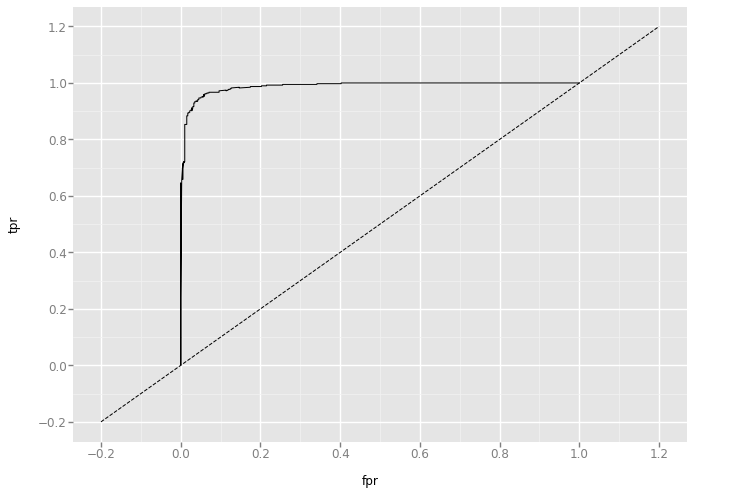

<ggplot: (8747815564822)>

In [57]:
ggplot(df, aes(x='fpr', y='tpr')) +\
    geom_line() + \
    geom_abline(linetype='dashed')

## Plots

In [58]:
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve
%matplotlib inline

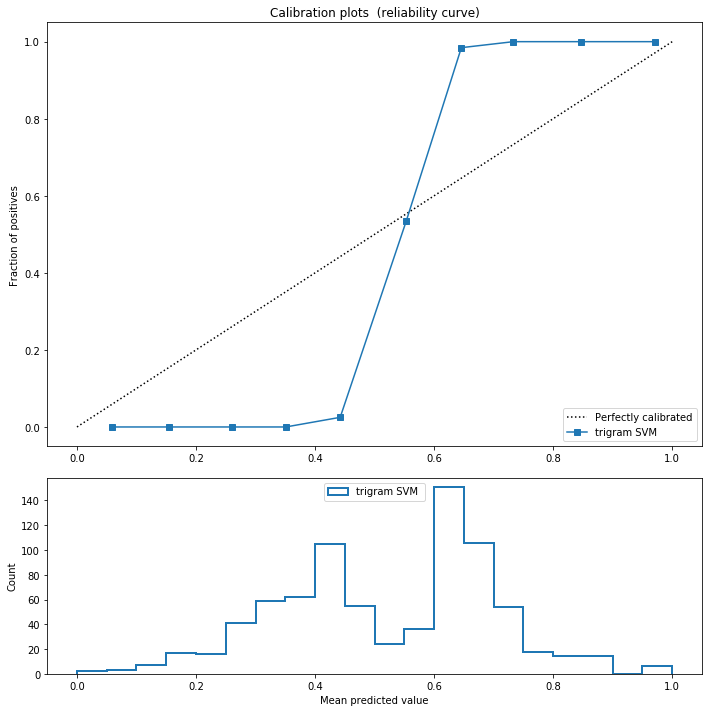

In [59]:
plt.figure(figsize=(10, 10))
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
ax2 = plt.subplot2grid((3, 1), (2, 0))

ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
for clf, name in [(svm_trigram_clf, 'trigram SVM ')]:
    clf.fit(train_X, train_y)
    if hasattr(clf, "predict_proba"):
        prob_pos = clf.predict_proba(test_X)[:, 1]
    else:  # use decision function
        prob_pos = clf.decision_function(test_X)
        prob_pos = \
            (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())
    fraction_of_positives, mean_predicted_value = \
        calibration_curve(test_y, prob_pos, n_bins=10)

    ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
             label="%s" % (name, ))

    ax2.hist(prob_pos, range=(0, 1), bins=20, label=name,
             histtype="step", lw=2)

ax1.set_ylabel("Fraction of positives")
ax1.set_ylim([-0.05, 1.05])
ax1.legend(loc="lower right")
ax1.set_title('Calibration plots  (reliability curve)')

ax2.set_xlabel("Mean predicted value")
ax2.set_ylabel("Count")
ax2.legend(loc="upper center", ncol=2)

plt.tight_layout()
plt.show()

#### Confusion matrix to show TP/ FP/ FN/ TN

In [60]:
from sklearn.metrics import confusion_matrix

confusion_matrix(test_y, y_pred)

array([[358,  37],
       [ 19, 376]])

[[358  37]
 [ 19 376]]
Normalized confusion matrix
[[ 0.91  0.09]
 [ 0.05  0.95]]


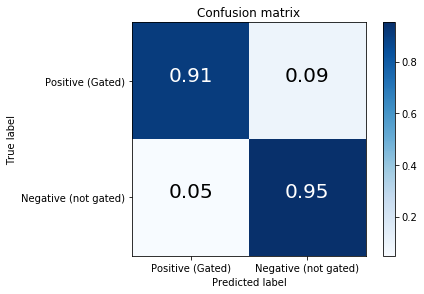

In [61]:
import matplotlib.pyplot as plt
# Compute confusion matrix
cm = confusion_matrix(test_y, y_pred)
np.set_printoptions(precision=2)
print(cm)
class_names = ['Positive (Gated)', 'Negative (not gated)']

import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    
    
    classes = class_names
    tick_marks = np.arange(len(classes)) 
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title('Confusion matrix')
    plt.colorbar()
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
   
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center", fontsize= 20,
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Compute confusion matrix
cnf_matrix = confusion_matrix(test_y, y_pred)
np.set_printoptions(precision=2)

# Show confusion matrix in a separate window

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,normalize=True,
                      title='Normalized confusion matrix')

In [62]:
trigram_clf.get_params()

{'classifier': LogisticRegression(C=2.0, class_weight=None, dual=False, fit_intercept=True,
           intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
           penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
           verbose=0, warm_start=False),
 'classifier__C': 2.0,
 'classifier__class_weight': None,
 'classifier__dual': False,
 'classifier__fit_intercept': True,
 'classifier__intercept_scaling': 1,
 'classifier__max_iter': 100,
 'classifier__multi_class': 'ovr',
 'classifier__n_jobs': 1,
 'classifier__penalty': 'l2',
 'classifier__random_state': None,
 'classifier__solver': 'liblinear',
 'classifier__tol': 0.0001,
 'classifier__verbose': 0,
 'classifier__warm_start': False,
 'steps': [('vectorizer',
   CountVectorizer(analyzer='word', binary=False, decode_error='strict',
           dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
           lowercase=True, max_df=1.0, max_features=10000, min_df=1,
           ngram_range=(1, 3), pr

### Trying grid search

In [63]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.datasets import load_digits
from scipy.stats import randint as sp_randint
from time import time

In [64]:
# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [65]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'gamma': [0.001, 0.01, 0.1, 1.0], 'kernel': ['linear','rbf']}

In [66]:
clf = GridSearchCV(trigram_clf, param_grid)

In [67]:
clf_GS = GridSearchCV(cv=5, estimator=LogisticRegression(C=1.0, intercept_scaling=1, dual=False, fit_intercept=True, penalty='l2', tol=0.0001),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]})

In [68]:
clf_GS.fit(X_transformed, train_y)

GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [69]:
clf_GS.best_params_

{'C': 1000}

In [70]:
clf_GS.best_estimator_

LogisticRegression(C=1000, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [71]:
clf_GS.best_score_

0.94803548795944237

In [72]:
trigram_clf.get_params().keys()

dict_keys(['classifier__class_weight', 'vectorizer__stop_words', 'vectorizer__preprocessor', 'transformer__sublinear_tf', 'classifier__solver', 'classifier__max_iter', 'steps', 'vectorizer__binary', 'vectorizer__input', 'vectorizer__max_df', 'vectorizer__dtype', 'vectorizer__ngram_range', 'classifier__random_state', 'classifier__fit_intercept', 'classifier__n_jobs', 'vectorizer__encoding', 'vectorizer__decode_error', 'classifier__multi_class', 'vectorizer__tokenizer', 'vectorizer', 'vectorizer__max_features', 'vectorizer__strip_accents', 'classifier__tol', 'classifier__penalty', 'classifier__C', 'vectorizer__min_df', 'classifier__verbose', 'classifier', 'transformer', 'transformer__use_idf', 'classifier__dual', 'transformer__smooth_idf', 'classifier__warm_start', 'vectorizer__vocabulary', 'vectorizer__analyzer', 'vectorizer__lowercase', 'transformer__norm', 'vectorizer__token_pattern', 'classifier__intercept_scaling'])

In [77]:
pd.DataFrame(clf_GS.cv_results_)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_C,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,...,split2_test_score,split2_train_score,split3_test_score,split3_train_score,split4_test_score,split4_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.020458,0.000598,0.836819,0.840701,0.001,{'C': 0.001},6,0.844937,0.838748,0.813291,...,0.846276,0.840000,0.835182,0.840792,0.844444,0.838084,0.003061,0.000009,0.012413,0.002756
1,0.026266,0.000591,0.819708,0.823115,0.01,{'C': 0.01},7,0.829114,0.821712,0.794304,...,0.833597,0.820198,0.816165,0.824158,0.825397,0.822249,0.000089,0.000006,0.013946,0.002428
2,0.033312,0.000595,0.865019,0.873336,0.1,{'C': 0.1},5,0.876582,0.872029,0.844937,...,0.868463,0.870495,0.862124,0.874851,0.873016,0.874109,0.000174,0.000006,0.011151,0.001797
3,0.046667,0.000597,0.923954,0.947719,1,{'C': 1},4,0.928797,0.947306,0.906646,...,0.927100,0.948119,0.933439,0.945743,0.923810,0.947743,0.000658,0.000009,0.009201,0.001272
4,0.070300,0.000599,0.946451,0.993425,10,{'C': 10},3,0.947785,0.993265,0.935127,...,0.950872,0.993267,0.944532,0.992475,0.953968,0.992874,0.002678,0.000010,0.006478,0.000956
5,0.110051,0.000600,0.947719,0.998970,100,{'C': 100},2,0.947785,0.999208,0.939873,...,0.949287,0.999208,0.946117,0.998812,0.955556,0.998812,0.005788,0.000006,0.005059,0.000194
6,0.147247,0.000599,0.948035,0.998970,1000,{'C': 1000},1,0.949367,0.999208,0.941456,...,0.950872,0.999208,0.946117,0.998812,0.952381,0.998812,0.013753,0.000009,0.003891,0.000194


In [75]:
trigram_clf.get_params().keys()

dict_keys(['classifier__class_weight', 'vectorizer__stop_words', 'vectorizer__preprocessor', 'transformer__sublinear_tf', 'classifier__solver', 'classifier__max_iter', 'steps', 'vectorizer__binary', 'vectorizer__input', 'vectorizer__max_df', 'vectorizer__dtype', 'vectorizer__ngram_range', 'classifier__random_state', 'classifier__fit_intercept', 'classifier__n_jobs', 'vectorizer__encoding', 'vectorizer__decode_error', 'classifier__multi_class', 'vectorizer__tokenizer', 'vectorizer', 'vectorizer__max_features', 'vectorizer__strip_accents', 'classifier__tol', 'classifier__penalty', 'classifier__C', 'vectorizer__min_df', 'classifier__verbose', 'classifier', 'transformer', 'transformer__use_idf', 'classifier__dual', 'transformer__smooth_idf', 'classifier__warm_start', 'vectorizer__vocabulary', 'vectorizer__analyzer', 'vectorizer__lowercase', 'transformer__norm', 'vectorizer__token_pattern', 'classifier__intercept_scaling'])